## Librerías necesarias

In [1]:
from sqlalchemy import create_engine
import pandas as pd



## Host

In [2]:
# Configuración de la conexión
host = "10.206.69.41"
port = "5432"
user = "desarrollo"
password = "171819.L05"
database = "datawarehouse"


# Crear el motor de conexión usando SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')


## Consulta del df requerido

In [3]:

# Definir la consulta
query = """
SELECT
    n.numero,
    c.renta,
    c.fecha_pago,
    c.estado,
    o.operador as operador_actual,
    o2.operador as operador_donante,
    o3.operador as operador_propietario,
    t.cantidad_portaciones,
    t.fecha_portacion
FROM
    numeros n
INNER JOIN
    caracas c ON c.id_numero = n.id_numero
INNER JOIN
    trinity t ON t.id_numero = c.id_numero
LEFT JOIN
    operadores o ON t.id_operador = o.id_operador
LEFT JOIN
    operadores o2 ON t.id_operador_donante = o2.id_operador
LEFT JOIN
    operadores o3 ON t.id_operador_propietario = o3.id_operador;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
try:
    df = pd.read_sql(query, engine)
    print("Datos cargados exitosamente")
except Exception as e:
    print("Error al ejecutar la consulta:", e)

# Mostrar los primeros datos
df.head()

Datos cargados exitosamente


,numero,renta,fecha_pago,estado,operador_actual,operador_donante,operador_propietario,cantidad_portaciones,fecha_portacion
0,3160510801,37990,2024-09-01,ACTIVO,MOVISTAR,None,None,0,None
1,3027636205,121747,2024-09-22,ACTIVO,MOVISTAR,WOM,WOM,3,2024-04-16
2,3165776061,28990,2024-10-08,ACTIVO,MOVISTAR,None,None,0,None
3,3157144810,39990,2024-09-01,ACTIVO,MOVISTAR,None,None,0,None
4,3163032025,22691,2024-09-13,ACTIVO,MOVISTAR,None,None,0,None


## df con los números que terminaron en venta

In [4]:
query_crm = """
select n.numero from numeros n 
inner join crm c on n.id_numero = c."Celular_gestionar" 

"""
# Ejecutar la consulta y cargar los datos en un DataFrame
try:
    df_crm = pd.read_sql(query_crm, engine)
    print("Datos cargados exitosamente")
except Exception as e:
    print("Error al ejecutar la consulta:", e)

# Mostrar los primeros datos
df_crm.head()

Datos cargados exitosamente


,numero
0,3142408722
1,3003784177
2,3165019429
3,3108639373
4,3108146047


In [5]:
df_crm['target'] = 1

In [6]:
data_set = pd.merge(df, df_crm, how = 'left', on = 'numero')

In [7]:
data_set['target'] = data_set['target'].fillna(0)



## Trasformación de datos

In [8]:
data_set['target'].value_counts()



# Convertir las columnas de fecha a formato datetime
data_set['fecha_pago'] = pd.to_datetime(data_set['fecha_pago'], errors='coerce')  # Convertir fecha_pago
data_set['fecha_portacion'] = pd.to_datetime(data_set['fecha_portacion'], errors='coerce')  # Convertir fecha_portacion

# Verificar la columna 'target'
# Si 'target' representa categorías discretas, convertirla a int si no hay decimales
if all(data_set['target'].dropna() == data_set['target'].dropna().astype(int)):
    data_set['target'] = data_set['target'].astype('Int64')  # Utiliza Int64 para manejar nulos
else:
    # Mantener como float si tiene decimales significativos
    pass

# Limpiar y convertir la columna 'renta' a enteros
data_set['renta'] = data_set['renta'].replace(',', '', regex=True)  # Reemplaza todas las comas en los valores
data_set['renta'] = data_set['renta'].astype(int)  # Convierte a enteros

# Información general del DataFrame
data_set.info()

# Estadísticas descriptivas de las columnas numéricas
data_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743695 entries, 0 to 1743694
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   numero                object        
 1   renta                 int64         
 2   fecha_pago            datetime64[ns]
 3   estado                object        
 4   operador_actual       object        
 5   operador_donante      object        
 6   operador_propietario  object        
 7   cantidad_portaciones  int64         
 8   fecha_portacion       datetime64[ns]
 9   target                Int64         
dtypes: Int64(1), datetime64[ns](2), int64(2), object(5)
memory usage: 134.7+ MB


,renta,fecha_pago,cantidad_portaciones,fecha_portacion,target
count,1.743695e+06,1743695,1.743695e+06,1113921,1743695.0
mean,5.309010e+04,2024-07-09 14:00:55.376198144,1.607574e+00,2022-11-29 23:51:28.621545472,0.012321
min,1.000000e+00,2024-01-02 00:00:00,0.000000e+00,2011-08-03 00:00:00,0.0
25%,2.808200e+04,2024-04-30 00:00:00,0.000000e+00,2022-03-01 00:00:00,0.0
50%,3.999000e+04,2024-07-30 00:00:00,1.000000e+00,2023-11-30 00:00:00,0.0
75%,5.713500e+04,2024-09-25 00:00:00,2.000000e+00,2024-05-22 00:00:00,0.0
max,8.652412e+07,2024-10-28 00:00:00,8.000000e+01,2024-11-20 00:00:00,1.0
std,1.122443e+05,NaN,1.955639e+00,NaN,0.110314


# Sección de gráficas

In [55]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Gráficas en base a renta y que fueron ventas

In [ ]:
# Filtrar el DataFrame para obtener solo las filas donde target es 1
data_set_target_1 = data_set[data_set['target'] == 1]

# Verificar el resultado
data_set_target_1.info()
data_set_target_1.describe()


In [ ]:
# Estadísticas descriptivas de 'renta' para 'target = 1'
print(data_set_target_1['renta'].describe())


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Calcular la media de 'renta' por 'cantidad_portaciones'
renta_por_portaciones = data_set_target_1.groupby('cantidad_portaciones')['renta'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
renta_por_portaciones.plot(kind='bar', color='lightblue')
plt.xlabel('Cantidad de Portaciones')
plt.ylabel('Renta Promedio')
plt.title('Renta Promedio por Cantidad de Portaciones para Target = 1')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Frecuencia de ventas por operador actual
plt.figure(figsize=(10, 6))
data_set_target_1['operador_actual'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Operador Actual')
plt.ylabel('Número de Ventas')
plt.title('Número de Ventas por Operador Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Frecuencia de ventas por operador donante
plt.figure(figsize=(10, 6))
data_set_target_1['operador_donante'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Operador Donante')
plt.ylabel('Número de Ventas')
plt.title('Número de Ventas por Operador Donante')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Frecuencia de ventas por operador propietario
plt.figure(figsize=(10, 6))
data_set_target_1['operador_propietario'].value_counts().plot(kind='bar', color='salmon')
plt.xlabel('Operador Propietario')
plt.ylabel('Número de Ventas')
plt.title('Número de Ventas por Operador Propietario')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. Tendencia de Ventas a lo Largo del Tiempo (fecha_pago)
Para ver si las ventas siguen algún patrón temporal, podemos hacer un gráfico de línea que muestre el número de ventas a lo largo del tiempo.

Interpretación: Este gráfico de línea muestra la cantidad de ventas en cada mes. Puedes observar si hay temporadas o meses específicos en los que las ventas son más altas, lo cual puede ser útil para identificar patrones estacionales.


In [ ]:
# Agrupar por mes y contar las ventas en cada mes
data_set_target_1['mes_pago'] = data_set_target_1['fecha_pago'].dt.to_period('M')
ventas_por_mes = data_set_target_1.groupby('mes_pago').size()

# Graficar la tendencia de ventas a lo largo del tiempo
plt.figure(figsize=(12, 6))
ventas_por_mes.plot(kind='line', marker='o', color='blue')
plt.xlabel('Fecha de Pago (Mes)')
plt.ylabel('Número de Ventas')
plt.title('Tendencia de Ventas a lo Largo del Tiempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Comparación de renta Promedio por Operador Actual
Para ver si hay alguna diferencia en la renta promedio entre diferentes operadores, podemos calcular y graficar la renta promedio para cada operador.

Interpretación: Este gráfico muestra la renta promedio para cada operador actual. Si algunos operadores tienen una renta promedio más alta, esto podría indicar que sus clientes tienen un mayor poder adquisitivo o que tienen más éxito en ventas de mayor valor.


In [ ]:
# Calcular la renta promedio por operador actual
renta_promedio_por_operador = data_set_target_1.groupby('operador_actual')['renta'].mean().sort_values()

# Graficar la renta promedio por operador
plt.figure(figsize=(12, 6))
renta_promedio_por_operador.plot(kind='bar', color='purple')
plt.xlabel('Operador Actual')
plt.ylabel('Renta Promedio')
plt.title('Renta Promedio por Operador Actual para Ventas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Crear gráfico de dispersión entre cantidad de portaciones y renta
plt.figure(figsize=(10, 6))
plt.scatter(data_set_target_1['cantidad_portaciones'], data_set_target_1['renta'], alpha=0.5, color='teal')
plt.xlabel('Cantidad de Portaciones')
plt.ylabel('Renta')
plt.title('Relación entre Cantidad de Portaciones y Renta para Ventas')
plt.tight_layout()
plt.show()


In [ ]:
# Crear intervalos de 100,000 para renta
data_set_target_1['renta_rango'] = pd.cut(data_set_target_1['renta'], bins=range(0, int(data_set_target_1['renta'].max()) + 10000, 10000))
renta_rango_counts = data_set_target_1['renta_rango'].value_counts().sort_index()

# Graficar distribución de renta en rangos de 100,000
plt.figure(figsize=(12, 6))
renta_rango_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Rango de Renta (Intervalos de 10,000)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Renta en Rangos de 100,000 para Ventas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Gráficas 

C:\Users\jesus.cochero\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


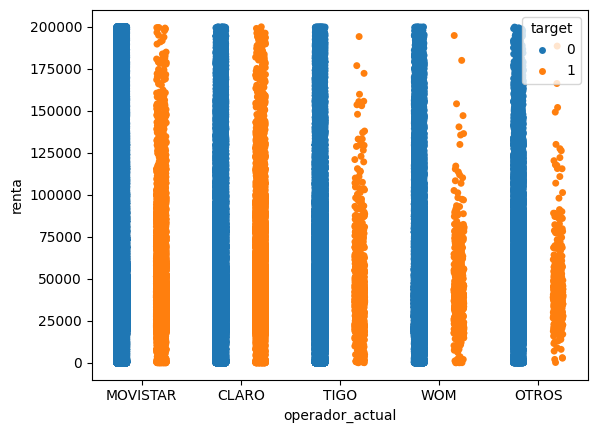

In [19]:
# Filtrar los datos para excluir valores de renta extremadamente altos
data_set_filtered = data_set[data_set['renta'] < 200000]  # Ajusta este valor según el rango esperado

sns.stripplot(x='operador_actual', y='renta', hue='target', data=data_set_filtered, dodge=True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

C:\Users\jesus.cochero\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


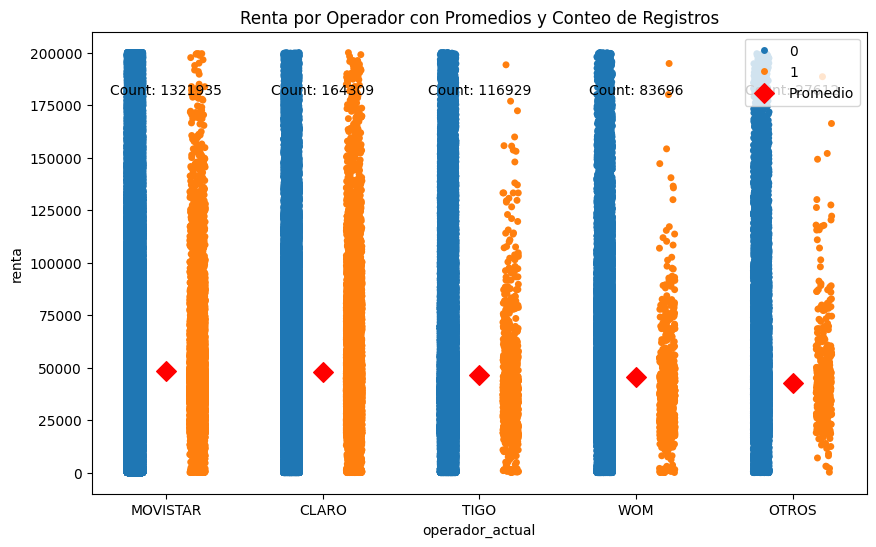

In [22]:
# Calcular el promedio de renta por operador
mean_renta = data_set_filtered.groupby('operador_actual')['renta'].mean()

# Calcular el conteo de registros por operador
count_data = data_set_filtered['operador_actual'].value_counts()

# Crear figura y ejes
plt.figure(figsize=(10, 6))

# Gráfico de puntos (stripplot)
sns.stripplot(x='operador_actual', y='renta', hue='target', data=data_set_filtered, dodge=True)

# Agregar el promedio de renta como puntos adicionales
for index, value in enumerate(mean_renta):
    plt.scatter(index, value, color='red', marker='D', s=100, label='Promedio' if index == 0 else "")

# Añadir etiquetas de conteo encima de cada categoría
for index, value in enumerate(count_data):
    plt.text(index, max(data_set_filtered['renta']) * 0.9, f'Count: {value}', ha='center', color='black')

# Desactivar notación científica en el eje Y y añadir leyenda
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Renta por Operador con Promedios y Conteo de Registros')
plt.show()


In [37]:
sns.pairplot(data=data_set_filtered, hue='target')

Error in callback <function flush_figures at 0x0000027B250F1120> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Distribución de Ventas por Operador
 * Un gráfico de barras puede mostrar la cantidad de ventas (target=1) y no ventas (target=0) para cada operador (operador_actual).

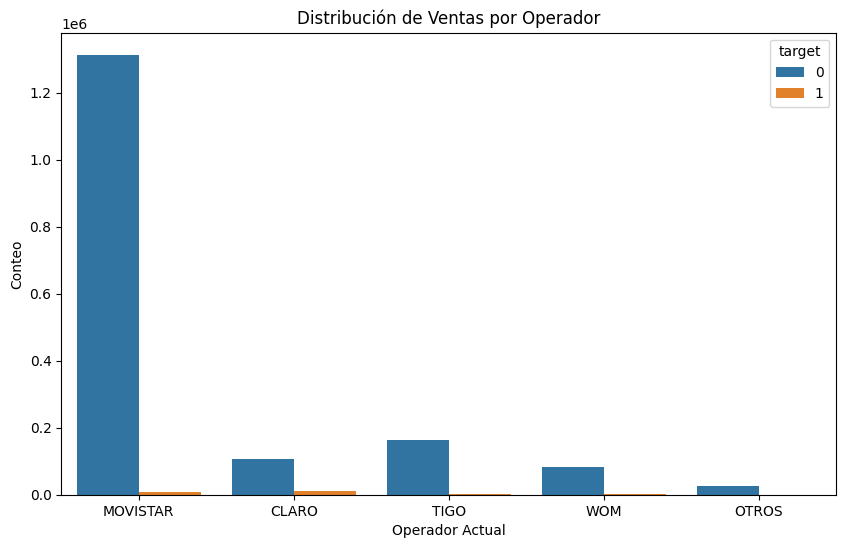

In [24]:


plt.figure(figsize=(10, 6))
sns.countplot(x='operador_actual', hue='target', data=data_set_filtered)
plt.title('Distribución de Ventas por Operador')
plt.xlabel('Operador Actual')
plt.ylabel('Conteo')
plt.show()


Renta vs. Cantidad de Portaciones por Operador
 * Este gráfico de dispersión puede mostrar si hay una relación entre la renta y la cantidad_portaciones de un cliente, segmentado por operador_actual.

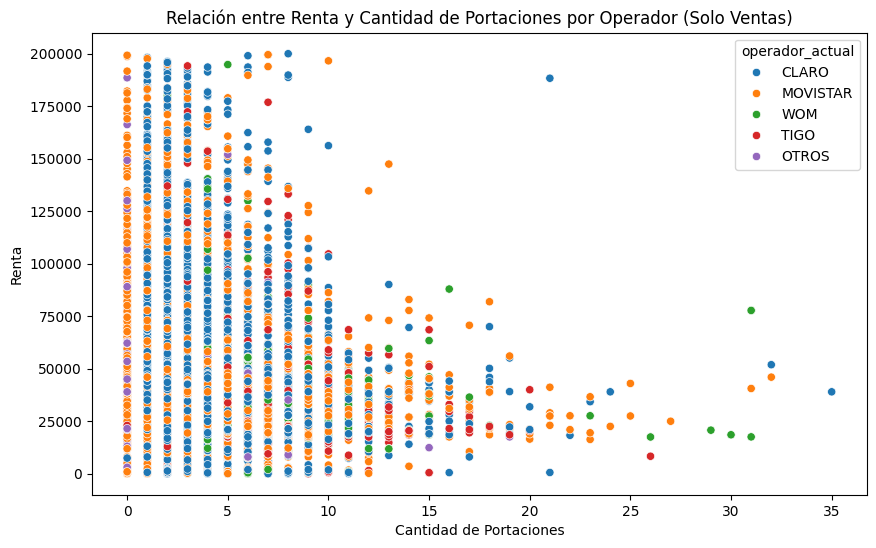

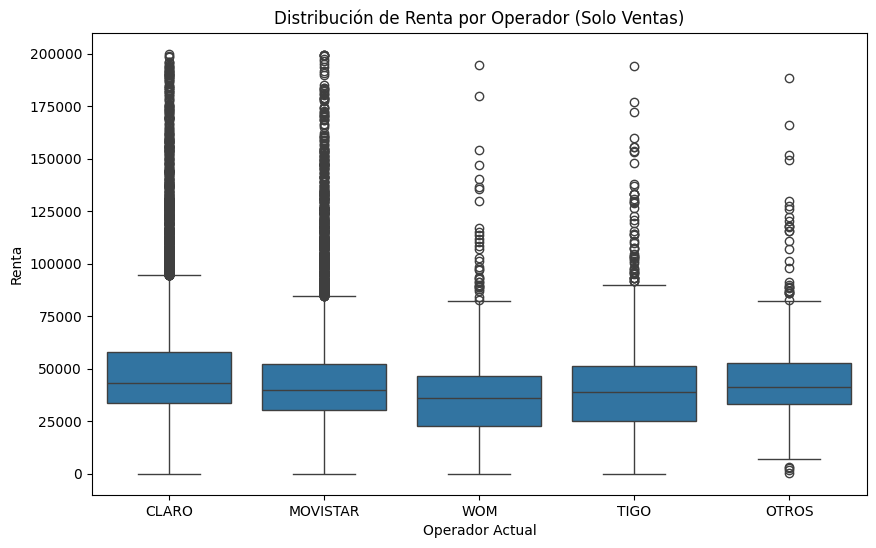

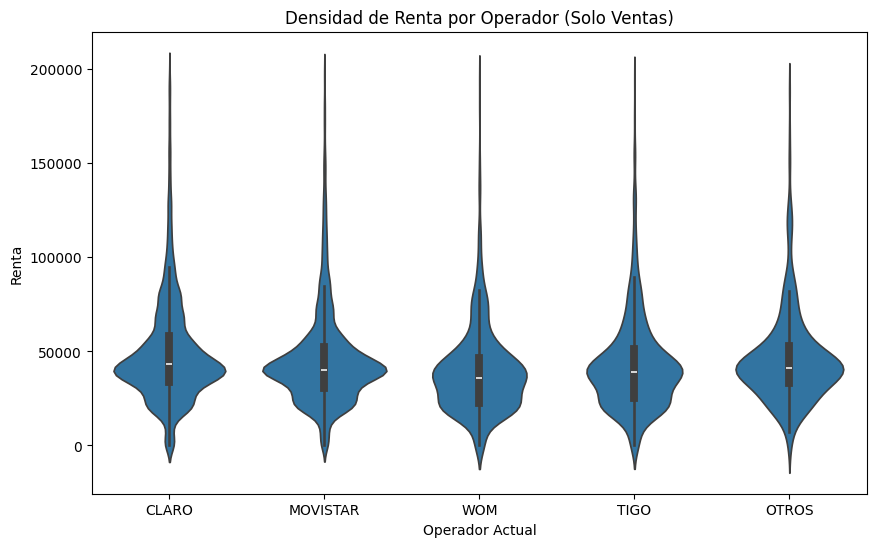

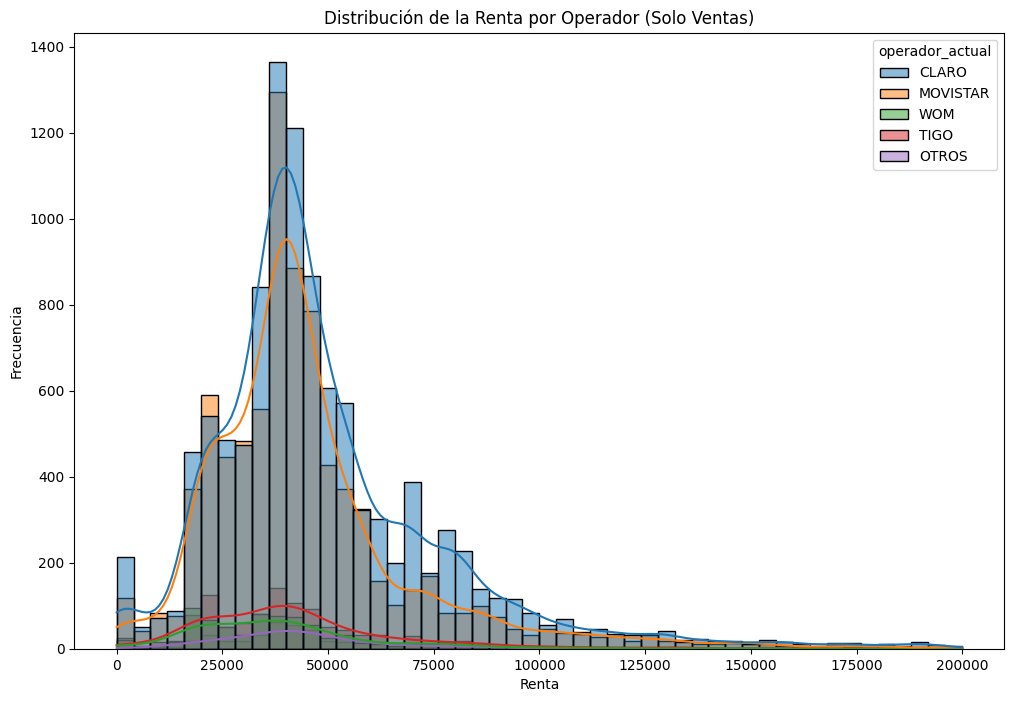

In [34]:
plt.figure(figsize=(10, 6))

# Filtrar solo los registros donde target = 1 (ventas)
data_ventas = data_set_filtered[data_set_filtered['target'] == 1]

# Crear el gráfico de dispersión con los datos filtrados
sns.scatterplot(x='cantidad_portaciones', y='renta', hue='operador_actual', data=data_ventas)
plt.title('Relación entre Renta y Cantidad de Portaciones por Operador (Solo Ventas)')
plt.xlabel('Cantidad de Portaciones')
plt.ylabel('Renta')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='operador_actual', y='renta', data=data_ventas)
plt.title('Distribución de Renta por Operador (Solo Ventas)')
plt.xlabel('Operador Actual')
plt.ylabel('Renta')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='operador_actual', y='renta', data=data_ventas)
plt.title('Densidad de Renta por Operador (Solo Ventas)')
plt.xlabel('Operador Actual')
plt.ylabel('Renta')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(data=data_ventas, x='renta', hue='operador_actual', bins=50, kde=True)
plt.title('Distribución de la Renta por Operador (Solo Ventas)')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')
plt.show()


Distribución de la Renta
* Si deseas ver cómo se distribuye la renta de todos los registros, puedes usar un histograma. Puedes separar los datos por target para ver si hay diferencias en las rentas entre ventas y no ventas.

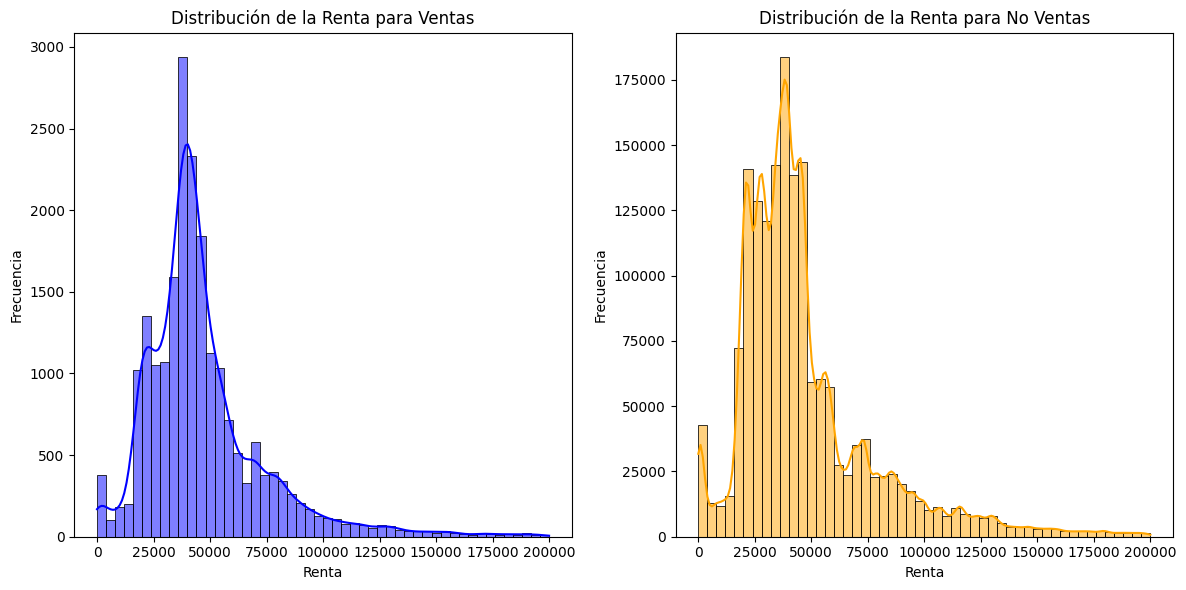

In [29]:
plt.figure(figsize=(12, 6))

# Gráfico para los registros donde target = 1 (ventas)
plt.subplot(1, 2, 1)
sns.histplot(data=data_set_filtered[data_set_filtered['target'] == 1], x='renta', bins=50, kde=True, color='blue')
plt.title('Distribución de la Renta para Ventas')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')

# Gráfico para los registros donde target = 0 (no ventas)
plt.subplot(1, 2, 2)
sns.histplot(data=data_set_filtered[data_set_filtered['target'] == 0], x='renta', bins=50, kde=True, color='orange')
plt.title('Distribución de la Renta para No Ventas')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


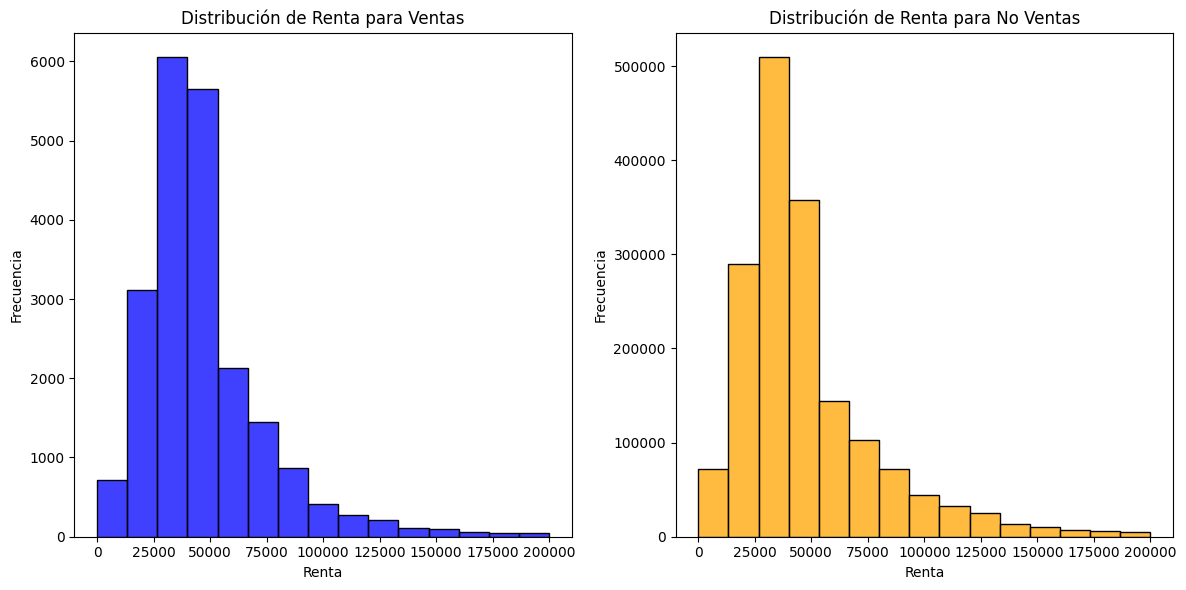

In [41]:


# Crear una figura con dos subplots
plt.figure(figsize=(12, 6))

# Histograma para ventas (target=1)
plt.subplot(1, 2, 1)
sns.histplot(data=data_set_filtered[data_set_filtered['target'] == 1], x='renta', bins=15, cumulative=False, color='blue')
plt.title('Distribución de Renta para Ventas')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')

# Histograma para no ventas (target=0)
plt.subplot(1, 2, 2)
sns.histplot(data=data_set_filtered[data_set_filtered['target'] == 0], x='renta', bins=15, cumulative=False, color='orange')
plt.title('Distribución de Renta para No Ventas')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')

# Ajuste del diseño
plt.tight_layout()
plt.show()


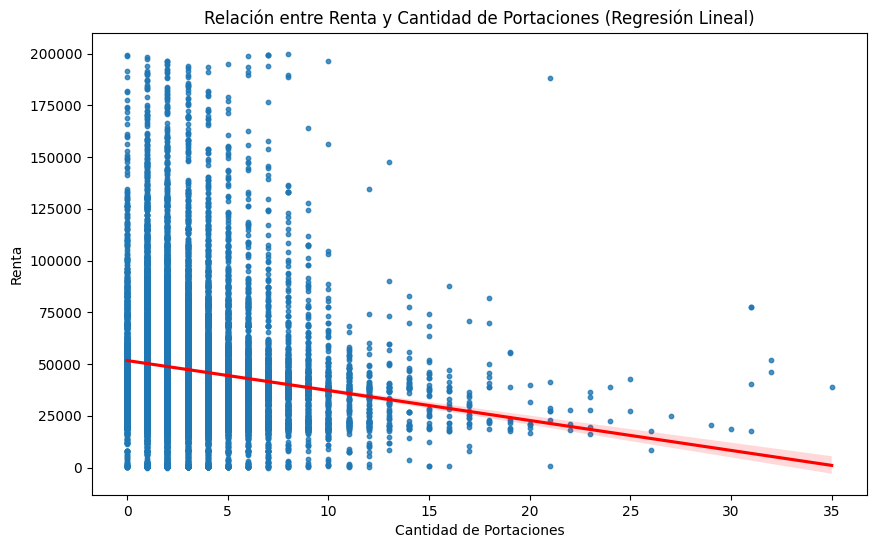

In [39]:
# Crear la gráfica de regresión lineal
plt.figure(figsize=(10, 6))
sns.regplot(x='cantidad_portaciones', y='renta', data=data_ventas, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title('Relación entre Renta y Cantidad de Portaciones (Regresión Lineal)')
plt.xlabel('Cantidad de Portaciones')
plt.ylabel('Renta')
plt.show()

¿Qué operadores tienen las tasas de venta más altas?
 * Esta pregunta puede darte una idea de cuáles operadores son más exitosos en términos de conversión de ventas. Puedes calcular la tasa de ventas como el porcentaje de target=1 para cada operador.

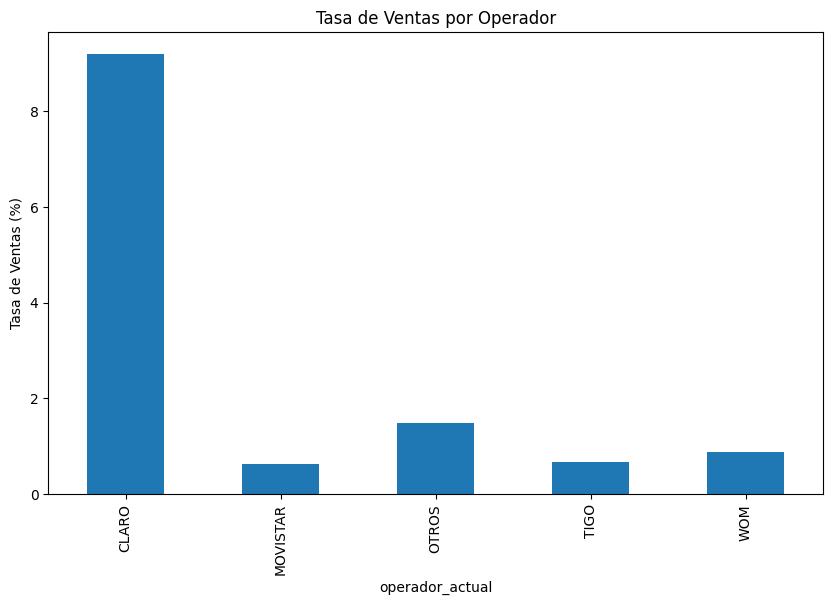

In [42]:
# Calcular la tasa de venta para cada operador
sales_rate = data_set_filtered.groupby('operador_actual')['target'].mean() * 100

# Graficar las tasas de venta
sales_rate.plot(kind='bar', figsize=(10, 6), title='Tasa de Ventas por Operador')
plt.ylabel('Tasa de Ventas (%)')
plt.show()


¿Cómo varía la renta según el operador_actual y el estado del cliente?
 * Esto te ayudará a ver si ciertos operadores o estados de clientes tienen rentas significativamente mayores o menores. Un boxplot puede mostrar cómo la renta se distribuye para cada combinación de operador_actual y estado.

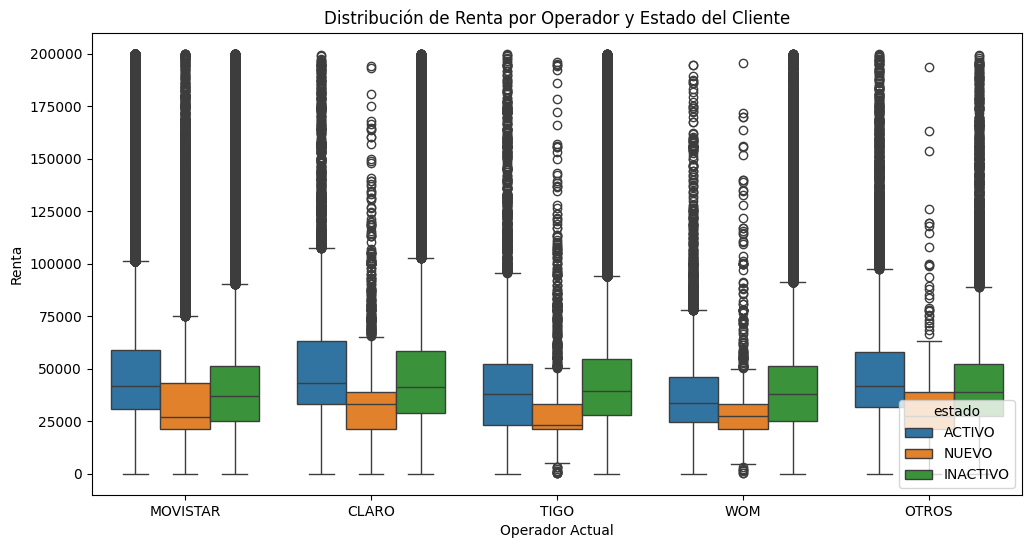

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_set_filtered, x='operador_actual', y='renta', hue='estado')
plt.title('Distribución de Renta por Operador y Estado del Cliente')
plt.xlabel('Operador Actual')
plt.ylabel('Renta')
plt.show()


 ¿Existe una relación entre la cantidad de portaciones y la probabilidad de venta?
* Para esta pregunta, podrías agrupar tus datos por rangos de cantidad_portaciones y calcular la tasa de ventas en cada grupo para ver si hay una tendencia clara.

C:\Users\jesus.cochero\AppData\Local\Temp\ipykernel_25960\1834243418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set_filtered['portaciones_bin'] = pd.cut(data_set_filtered['cantidad_portaciones'], bins=[0, 1, 5, 10, 20, 35])
C:\Users\jesus.cochero\AppData\Local\Temp\ipykernel_25960\1834243418.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portaciones_sales_rate = data_set_filtered.groupby('portaciones_bin')['target'].mean() * 100


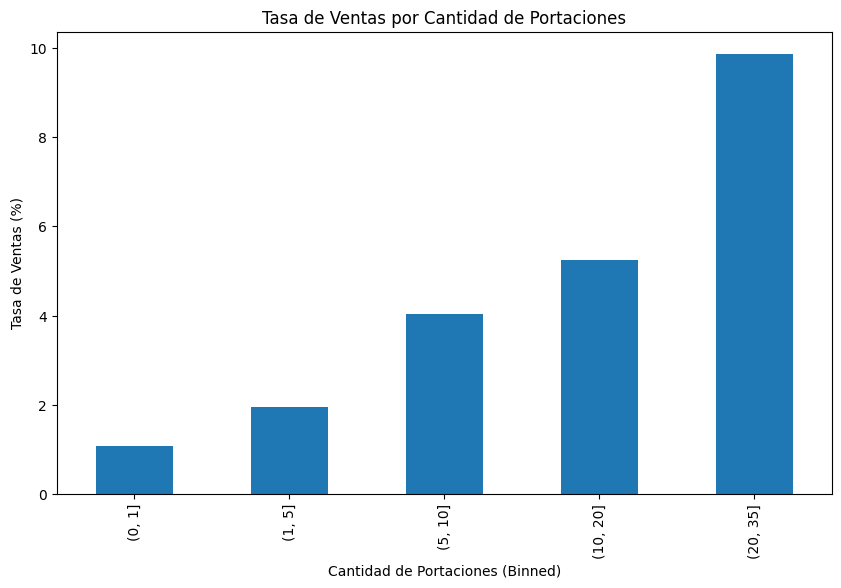

In [44]:
# Agrupar en bins para cantidad de portaciones
data_set_filtered['portaciones_bin'] = pd.cut(data_set_filtered['cantidad_portaciones'], bins=[0, 1, 5, 10, 20, 35])

# Calcular tasa de ventas por bin de cantidad de portaciones
portaciones_sales_rate = data_set_filtered.groupby('portaciones_bin')['target'].mean() * 100

# Graficar la tasa de ventas
portaciones_sales_rate.plot(kind='bar', figsize=(10, 6), title='Tasa de Ventas por Cantidad de Portaciones')
plt.ylabel('Tasa de Ventas (%)')
plt.xlabel('Cantidad de Portaciones (Binned)')
plt.show()


Segmentación de Clientes por Renta y Cantidad de Portaciones
* Puedes intentar segmentar a los clientes en grupos según sus valores de renta y cantidad_portaciones usando clustering, como K-means. Esto puede ayudarte a identificar segmentos de clientes con diferentes características.

C:\Users\jesus.cochero\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


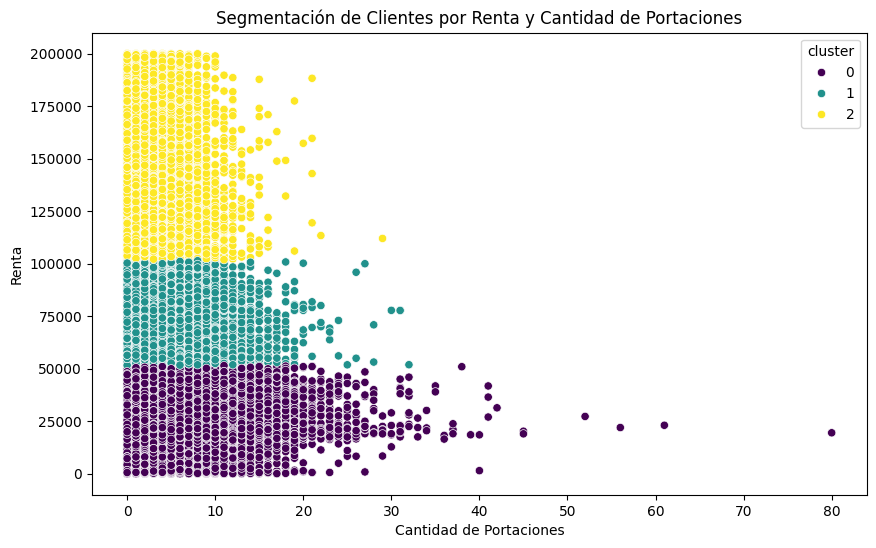

In [56]:

# Seleccionar solo columnas numéricas y remover NaN
data_for_clustering = data_set_filtered[['renta', 'cantidad_portaciones']].dropna()

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0)
data_for_clustering['cluster'] = kmeans.fit_predict(data_for_clustering)

# Graficar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_clustering, x='cantidad_portaciones', y='renta', hue='cluster', palette='viridis')
plt.title('Segmentación de Clientes por Renta y Cantidad de Portaciones')
plt.xlabel('Cantidad de Portaciones')
plt.ylabel('Renta')
plt.show()


Tendencias Temporales (si tienes datos de fecha)
* Si tienes datos de fechas en fecha_pago o fecha_portacion, puedes analizar cómo ha cambiado la renta o el número de ventas a lo largo del tiempo.

C:\Users\jesus.cochero\AppData\Local\Temp\ipykernel_25960\3446020713.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data_set_filtered.resample('M', on='fecha_pago').agg({'renta': 'mean', 'target': 'sum'})


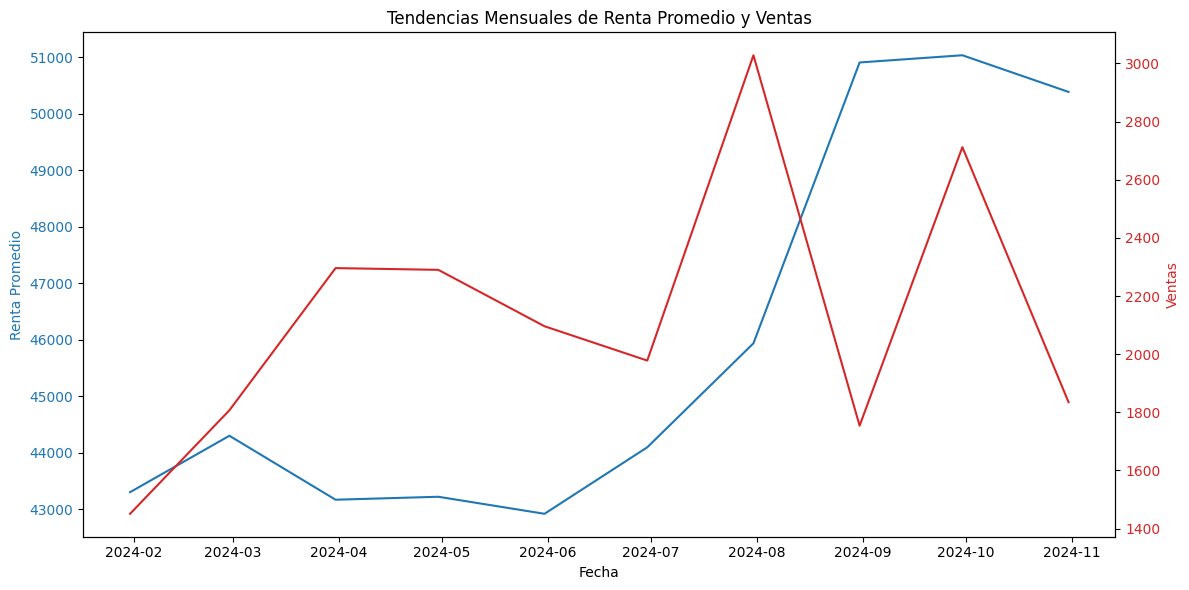

In [57]:
# Agrupar por mes y calcular el promedio de renta y el total de ventas
monthly_data = data_set_filtered.resample('M', on='fecha_pago').agg({'renta': 'mean', 'target': 'sum'})

# Graficar renta promedio y ventas mensuales
fig, ax1 = plt.subplots(figsize=(12, 6))

# Renta promedio
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Renta Promedio', color='tab:blue')
ax1.plot(monthly_data.index, monthly_data['renta'], color='tab:blue', label='Renta Promedio')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ventas mensuales
ax2 = ax1.twinx()
ax2.set_ylabel('Ventas', color='tab:red')
ax2.plot(monthly_data.index, monthly_data['target'], color='tab:red', label='Ventas')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Tendencias Mensuales de Renta Promedio y Ventas')
fig.tight_layout()
plt.show()
